In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from calendar import monthrange
from palettable.colorbrewer.sequential import *

In [2]:
# Calculate seconds in each month from 1980 - 1980
seconds = np.zeros(12); seconds[:] = np.nan
count = -1
for year in range(1980, 1980 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60

# Path
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Precipitation
sn = xr.open_dataset(data_path + "PRECSN_monthly_1980.nc")
ls = xr.open_dataset(data_path + "PRECLS_monthly_1980.nc")
cu = xr.open_dataset(data_path + "PRECCU_monthly_1980.nc")

# Evaporation 
evap = xr.open_dataset(data_path + "EVAP_monthly_1980.nc")

# SMB
smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
smb = smb.mean(dim='month') * seconds.mean() * 12
smb = np.transpose(smb.values)
smb.shape

(576, 101)

In [3]:
a3d = xr.open_dataset("../../nc_storage/450.nc")

# Load Alpine-3D topography 
dem = np.flipud(np.loadtxt("../input/surface-grids/dem.asc", skiprows=6))
dem = xr.DataArray(dem, coords=[a3d['northing'], a3d['easting']], dims=['northing', 'easting'])


n_trim = 15 # 1 is also reasonable it looks like
a3d = a3d.isel(easting=slice(n_trim, -n_trim))
a3d = a3d.isel(northing=slice(n_trim, -n_trim))
dem = dem.isel(easting=slice(n_trim, -n_trim))
dem = dem.isel(northing=slice(n_trim, -n_trim))
x_min = float(a3d['easting'].min().values)
x_max = float(a3d['easting'].max().values)
y_min = float(a3d['northing'].min().values)
y_max = float(a3d['northing'].max().values)
bump = 100 * 1000

# Translate MERRA-2 lat/lon to EPSG:3031

In [4]:
# First create a meshgrid of lat/lon
shape = (len(sn['lon']), len(sn['lat']))
X = np.zeros(shape)
Y = np.zeros(shape)
Y.shape

(576, 101)

In [5]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Perform transformation
for j in range(0, shape[0]): # Lon
    for k in range(0, shape[1]): # Lat
        coords = transform.TransformPoint(float(sn['lat'][k].values), float(sn['lon'][j].values)) # Lat, Lon
        X[j, k], Y[j, k] = coords[0:2]
        
        if X[j, k] > (x_max + bump) or X[j, k] < (x_min  - bump):
            smb[j, k] = np.nan
        if Y[j, k] > (y_max + bump) or Y[j, k] < (y_min - bump):
            smb[j, k] = np.nan

# Flatten arrays

In [6]:
n_sample = 1
X_plot = X.flatten()[::n_sample]
Y_plot = Y.flatten()[::n_sample]
smb_plot = smb.flatten()[::n_sample]

X_plot = X_plot[~np.isnan(smb_plot)]
Y_plot = Y_plot[~np.isnan(smb_plot)]
smb_plot = smb_plot[~np.isnan(smb_plot)]

print(X_plot.shape)
print(Y_plot.shape)
print(smb_plot.shape)

(135,)
(135,)
(135,)


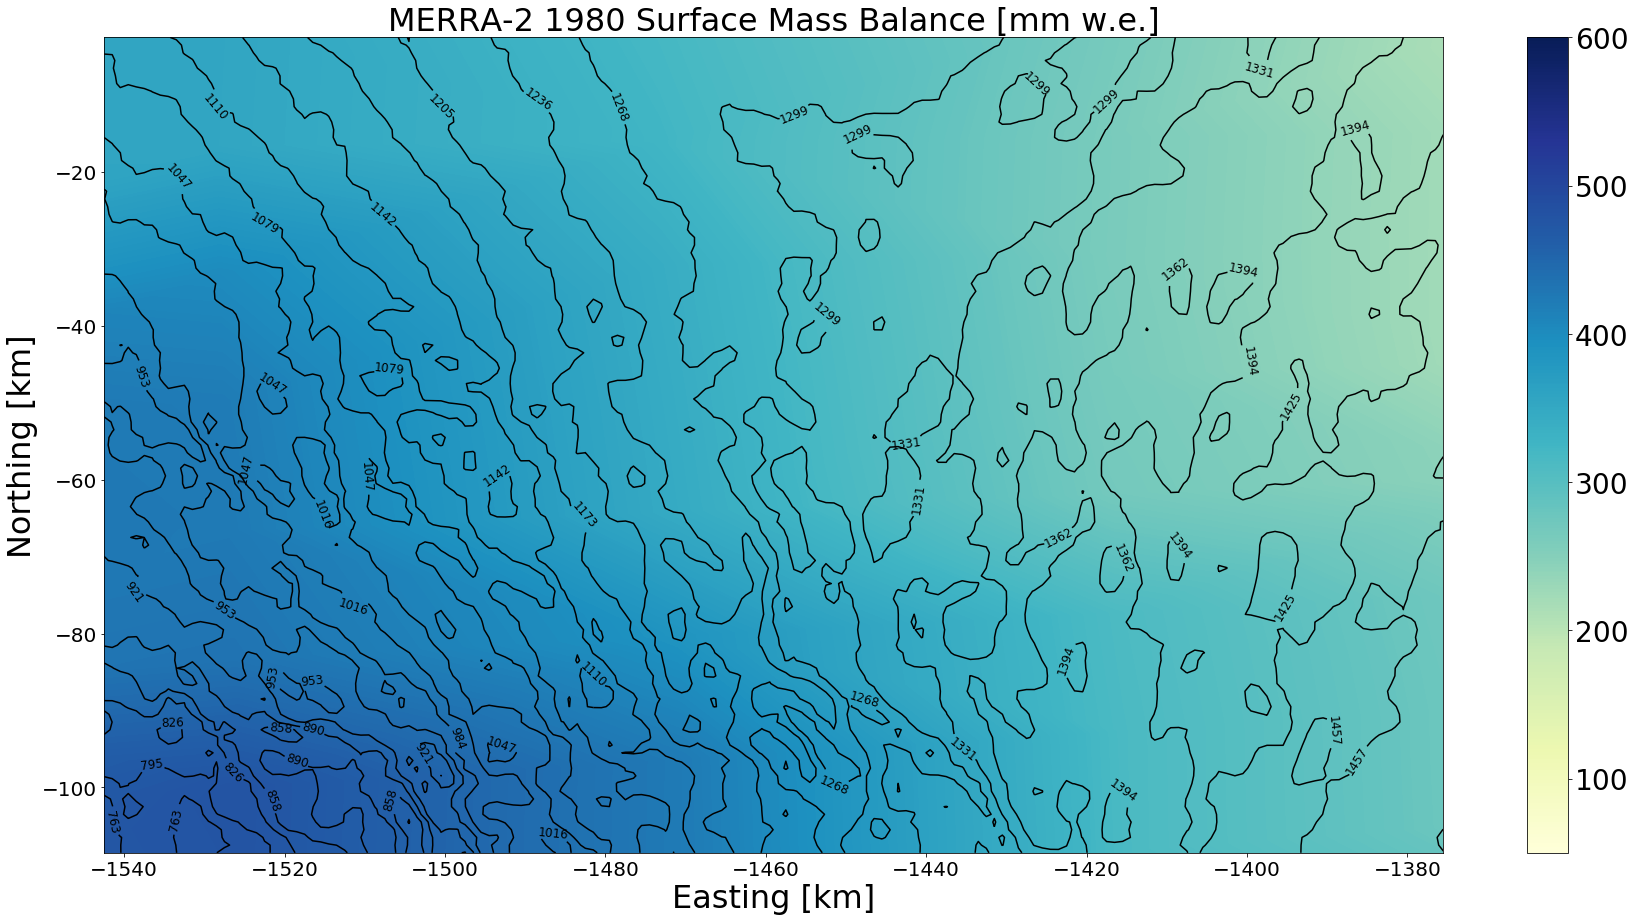

In [11]:
fig = plt.figure(figsize=(30,15))

# DEM
contour_levels = np.linspace(dem.min(), dem.max(), 25)
contour = plt.contour((dem['easting'] / 1000).values, (dem['northing'] / 1000).values, dem, contour_levels, linestyles='solid', colors='black')
plt.clabel(contour, fontsize=12, fmt = '%.0f', inline = True)

colormap=YlGnBu_9.mpl_colormap
bounds=np.linspace(50, 600, 500)
mesh = plt.tricontourf(X_plot / 1000, Y_plot/ 1000, smb_plot, 500, cmap=colormap, vmin=50, vmax=600, levels=bounds)
plt.xlim([x_min/1000, x_max/1000])
plt.ylim([y_min/1000, y_max/1000])
cbar = plt.colorbar(mesh, ticks=np.arange(100, 700, 100))
cbar.ax.tick_params(labelsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title('MERRA-2 1980 Surface Mass Balance [mm w.e.]', fontsize=32)
plt.savefig("MERRA2_meteorology.pdf", dpi=100)